In [13]:
#neccessary libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras import layers, losses
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.neighbors import KernelDensity

In [2]:
#generates train and anomaly data

datagen = ImageDataGenerator(rescale = 1./255)

train_generator = datagen.flow_from_directory(
    r"C:\cv project\train\empty", 
    target_size = (224,224), #original size of images is 3000 x 4000
    batch_size=64,
    class_mode='input')


anomaly_generator = datagen.flow_from_directory(
    r"C:\cv project\train\not empty", 
    target_size = (224,224),
    batch_size=64,
    class_mode='input')

Found 336 images belonging to 1 classes.
Found 147 images belonging to 1 classes.


In [4]:
model = Sequential()

#encoder 
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2), padding = 'same'))

#decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding = 'same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(3, (3,3), activation = 'sigmoid', padding = 'same'))

model.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 16)       

In [7]:
history = model.fit(train_generator, steps_per_epoch=1, epochs= 50, shuffle=True)

Epoch 1/50
1/1 [==============================] - 12s 12s/step - loss: 0.0634 - mse: 0.0634
Epoch 2/50
1/1 [==============================] - 13s 13s/step - loss: 0.0590 - mse: 0.0590
Epoch 3/50
1/1 [==============================] - 13s 13s/step - loss: 0.0567 - mse: 0.0567
Epoch 4/50
1/1 [==============================] - 12s 12s/step - loss: 0.0535 - mse: 0.0535
Epoch 5/50
1/1 [==============================] - 12s 12s/step - loss: 0.0503 - mse: 0.0503
Epoch 6/50
1/1 [==============================] - 11s 11s/step - loss: 0.0485 - mse: 0.0485
Epoch 7/50
1/1 [==============================] - 11s 11s/step - loss: 0.0466 - mse: 0.0466
Epoch 8/50
1/1 [==============================] - 12s 12s/step - loss: 0.0444 - mse: 0.0444
Epoch 9/50
1/1 [==============================] - 12s 12s/step - loss: 0.0426 - mse: 0.0426
Epoch 10/50
1/1 [==============================] - 12s 12s/step - loss: 0.0418 - mse: 0.0418
Epoch 11/50
1/1 [==============================] - 13s 13s/step - loss: 0.0385 

Text(0, 0.5, 'Loss')

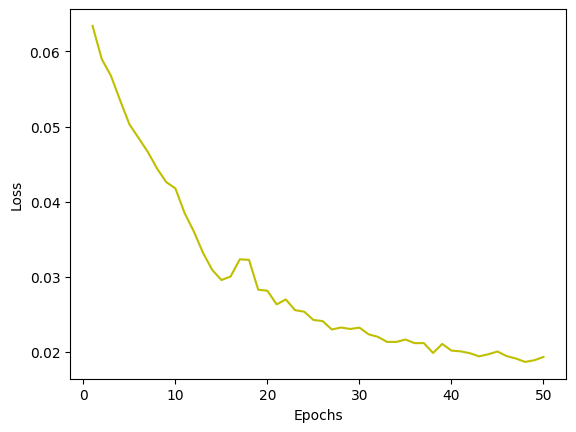

In [8]:
loss = history.history['loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'y')
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [9]:
img_num = 0
data_batch= [] #converting images into arrays 

while img_num <= train_generator.batch_index:
    data = train_generator.next()
    data_batch.append(data[0])
    img_num+=1
    
predicted = model.predict(data_batch[0]) #predicting 1st batch of images

predicted.shape

2/2 [==============================] - 1s 583ms/step


(64, 224, 224, 3)

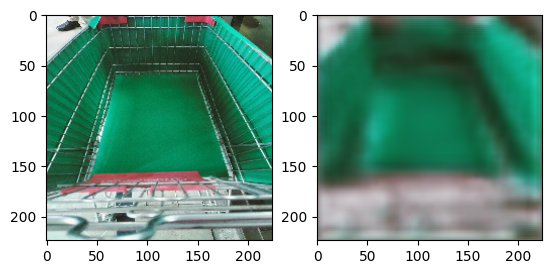

In [10]:
image_num = random.randint(0,predicted.shape[0])
plt.subplot(121)
plt.imshow(data_batch[0][image_num])
plt.subplot(122)
plt.imshow(predicted[image_num])
plt.show()

In [11]:
encoder_model = Sequential()

#using same weights of "model" 
encoder_model.add(Conv2D(64,(3,3),activation='relu',padding = 'same', input_shape=(224,224,3), 
                         weights = model.layers[0].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding = 'same'))

encoder_model.add(Conv2D(32,(3,3),activation='relu',padding = 'same',  
                         weights = model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding = 'same'))

encoder_model.add(Conv2D(16,(3,3),activation='relu',padding = 'same',  
                         weights = model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding = 'same'))

encoder_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 28, 28, 16)       

In [14]:
encoded_images = encoder_model.predict_generator(train_generator)
encoder_output_shape = encoder_model.output_shape
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]
encoded_images_vector = [np.reshape(img,(out_vector_shape)) for img in encoded_images]

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

C:\Users\user\AppData\Local\Temp\ipykernel_22464\4081745436.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator)


In [15]:
#to check if image is an anomaly or not

def check_anomaly(img_path):

    #thresholds for determining anomaly
    density_threshold = 8500 
    reconstruction_error_threshold = 0.0222
    
    img = Image.open(img_path)
    img = np.array(img.resize((224,224), Image.ANTIALIAS))
    plt.imshow(img)
    img = img/255.
    img = img[np.newaxis, :,:,:]

    #to calculate density
    encoded_img = encoder_model.predict([[img]])
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]
    density = kde.score_samples(encoded_img)[0]
    
    #to calculate mean squared error
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction], [[img]], batch_size=1)[0]
   
    print("Reconstruction error: ", reconstruction_error * 1000)
    print("Density: ",density)

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
    else:
        print("The image is NOT an anomaly")

C:\Users\user\AppData\Local\Temp\ipykernel_22464\2939942282.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((224,224), Image.ANTIALIAS))


1/1 [==============================] - 0s 156ms/step - loss: 0.0205 - mse: 0.0205
Reconstruction error:  20.4506553709507
Density:  8512.951134550503
The image is NOT an anomaly


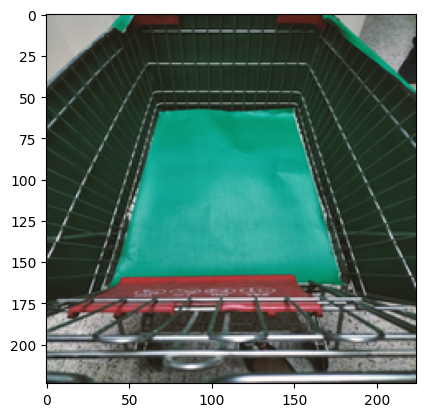

In [16]:
empty_path = r"C:\cv project\train\empty\images\IMG20231220155611.jpg"
check_anomaly(empty_path)

C:\Users\user\AppData\Local\Temp\ipykernel_22464\2939942282.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((224,224), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step - loss: 0.0199 - mse: 0.0199
Reconstruction error:  19.945114850997925
Density:  7861.089308202195
The image is an anomaly


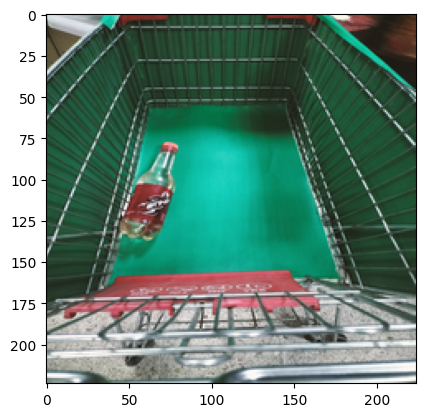

In [17]:
not_empty_path = r"C:\cv project\train\not empty\images\IMG20231226163746_01.jpg"
check_anomaly(not_empty_path)

In [19]:
#converting out model to TF Lite for using in Android Studio

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
    f.write (tflite_model)

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp9eifxunv\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp9eifxunv\assets
